- Plantear baseline / mvp
- Ventas -> + vendidos || + ingresos generan
- Rango de precios (premium, normal, etc...)
- Influencia de eventos en las ventas de los productos  
  
- Mantener las dimensiones por debajo de 4 a ser posible

# INIT

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [4]:
# !pip install featuretools # install the missing module # No lo vamos a usar esta vez

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

# Creacion caracteristicas
#import featuretools as ft

# Preprocesamiento
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler # Para evitar valores negativos

# Kmeans & PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
# from modules import feature_creation_module as fcm
from modules import time_series_analisis as tma

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Constantes

In [6]:
CLUSTER_COL = 'cluster'
FIGSIZE = (12, 8)
FIG_SQUARE = (10,10)

## Importacion datos

### CSVs

In [7]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_s = get_data('daily_sales_with_events.csv')

In [8]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_s.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [9]:
# Seleccionar solo años 2014 a 2016 de df_s
df_s = df_s[(df_s['year'] >= 2014) & (df_s['year'] <= 2016)]

# df_s_origin = df_s.copy() # Para recuperar eventos

# Cambiamos NaN de event por None
df_s['event'] = df_s['event'].fillna('None')

In [10]:
df_s.shape

(9693001, 12)

In [11]:
df_s.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8857275,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear
8857276,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear
8857277,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear
8857278,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear
8857279,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear


___
___

# SEGMENTACION

## Functions

In [12]:
# Librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# CONSTANTES
FIGSIZE = (12, 6)
CLUSTER_COL = 'cluster'
SCALER = RobustScaler

In [14]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

In [15]:
# 1. Preparación de datos
def prepare_data(df):
    df['date'] = pd.to_datetime(df['date'])
    # Renombramos raw_earn a total_sales
    df.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return df

# 2. Crear features
def features_creation(df):
    product_data = df.groupby('item').agg({
        'sell_price': ['mean', 'median', 'std', 'min', 'max'],
        # 'units': ['sum', 'mean'],
        # 'total_sales': ['sum', 'mean']
    }).reset_index()

    product_data.columns = [
                            'item',
                            'avg_price',
                            'median_price',
                            'price_std',
                            'min_price',
                            'max_price', # Vamos a probar solo con las relativas al precio
                            # 'total_units',
                            # 'avg_units',
                            # 'total_sales',
                            # 'avg_sales'
                            ]

    product_data['price_range'] = product_data['max_price'] - product_data['min_price']
    product_data['price_volatility'] = product_data['price_std'] / product_data['avg_price']
    # product_data['sales_per_unit'] = product_data['total_sales'] / product_data['total_units']
    # product_data['avg_sale_size'] = product_data['avg_sales'] / product_data['avg_units']

    features = product_data.columns.tolist()
    features.remove('item')
    df_features = product_data[features]

    # return product_data, features
    return df_features, features, product_data

# # 3. Segmentación de productos usando K-means con RobustScaler
# 3.1 - Grafico silueta
def plot_silhouette(data_scaled, ran=20):

  silhouette_scores = []

  for k in range(2, ran):
      kmeans = init_kmeans(k)
      kmeans.fit(data_scaled)
      silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

  fig = px.line(
      x=range(2, 20),
      y=silhouette_scores,
      title="Silhouette score",
      labels={"x": "k", "y": "Silhouette score"},
  )
  fig.show()

# 3.2 - Segementacion con optimal_k
def segment_products_kmeans(df, n_clusters=3):

    # FEATURE TOOLS -> helper
    X = data['df_features']
    features = data['features']
    product_data = data['product_data']
    X_scaled = data['X_scaled']
    scaler = data['scaler']
    # END FEATURE TOOLS

    # Aplica Kmeans sobre DF scalado -> helper
    kmeans = init_kmeans(n_clusters)
    product_data[CLUSTER_COL] = kmeans.fit_predict(X_scaled)

    # Calcula Silueta
    silhouette_avg = silhouette_score(X_scaled, product_data[CLUSTER_COL])
    print(f"El score de silueta promedio es: {silhouette_avg}")

    # Obtiene centroides y los devuelve en un DF
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids, columns=features)
    centroid_df[CLUSTER_COL] = range(n_clusters)
    print("\nCentroides de los clusters:")
    print(centroid_df)

    return product_data, centroid_df

# 4. Análisis de eventos integrado con segmentación
def analyze_segments(df, product_segments):
    # Unir df con product_segments en base a 'item'
    df = df.merge(product_segments[['item', 'cluster']], on='item', how='left')

    # Agrupar por cluster y calcular estadísticas agregadas
    cluster_analysis = df.groupby('cluster').agg({
        'total_sales': 'sum',
        'units': 'sum',
        'sell_price': 'mean'  # Precio promedio de venta
    }).reset_index()

    # Visualización de las ventas totales por cluster
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster', y='total_sales', data=cluster_analysis, palette='viridis')
    ax.set_title('Ventas totales por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Ventas totales')
    # Añadir las cifras encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

    # Visualización de las unidades vendidas por cluster
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster', y='units', data=cluster_analysis, palette='viridis')
    ax.set_title('Unidades vendidas por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Unidades vendidas')
    # Añadir las cifras encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

    # Visualización del precio de venta promedio por cluster
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster', y='sell_price', data=cluster_analysis, palette='viridis')
    ax.set_title('Precio de venta promedio por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Precio de venta promedio')
    # Añadir las cifras encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

    return cluster_analysis

# 5. Visualización de resultados
def visualize_results(product_segments, centroid_df):
    # Visualización de clusters según ventas totales y precio promedio
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=product_segments, x='total_sales', y='avg_price', hue=CLUSTER_COL, palette='viridis', s=100)
    sns.scatterplot(data=centroid_df, x='total_sales', y='avg_price', s=200, color='red', marker='X')
    plt.title('Segmentación de productos por ventas y precio promedio')
    plt.xlabel('Ventas totales')
    plt.ylabel('Precio de venta promedio')
    plt.legend(title='Cluster')
    plt.show()

In [16]:
print('DONE')

DONE


## Load data

In [17]:
items = df_items.copy()
shops = df_shops.copy()
df_pr = df_s.copy()

display(df_pr.shape)

(9693001, 12)

In [18]:
# Añadimos category a df_pr desde items
df_pr = df_pr.merge(items[['item', 'category']], on='item', how='left')

In [19]:
df_pr.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event,category
0,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear,ACCESORIES
1,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear,ACCESORIES
2,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear,ACCESORIES
3,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear,ACCESORIES
4,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear,ACCESORIES


## MAX PRICE = BASE PRICE

In [20]:
def scatter_plot_price_vs_units(df_pr):
    # Agrupar por 'item' y calcular el precio máximo y la suma de unidades vendidas
    grouped_data = df_pr.groupby('item').agg({
        'sell_price': 'max',  # Precio máximo por item
        'units': 'sum'       # Suma de unidades vendidas por item
    }).reset_index()

    # Renombramos columna sell_price a max_price
    grouped_data.rename(columns={'sell_price': 'max_price'}, inplace=True)

    # Calcular los cuartiles y la mediana del precio máximo
    q1 = grouped_data['max_price'].quantile(0.25)
    q3 = grouped_data['max_price'].quantile(0.75)
    median = grouped_data['max_price'].median()

    # Crear una nueva columna para la categoría de color
    conditions = [
        (grouped_data['max_price'] <= q1),  # Debajo de Q1
        (grouped_data['max_price'] > q1) & (grouped_data['max_price'] <= q3),  # Entre Q1 y Q3
        (grouped_data['max_price'] > q3)   # Por encima de Q3
    ]
    choices = ['Below Q1', 'Between Q1 and Q3', 'Above Q3']
    grouped_data['price_category'] = np.select(conditions, choices, default='Unknown')

    # Crear el scatter plot
    plt.figure(figsize=(12, 4))

    # Scatter plot con la escala de color basada en la categoría de precio
    scatter = sns.scatterplot(data=grouped_data, x='max_price', y='units', hue='price_category', palette='bright')

    # # Invertir el eje x para que vaya del precio máximo al mínimo
    # plt.gca().invert_xaxis()

    # Añadir líneas discontinuas para Q1, Q3 y la mediana
    plt.axvline(x=q1, color='gray', linestyle='--', label=f'Q1: {q1:.2f}', linewidth=0.3)
    plt.axvline(x=median, color='orange', linestyle='--', label=f'Mediana: {median:.2f}', linewidth=0.3)
    plt.axvline(x=q3, color='gray', linestyle='--', label=f'Q3: {q3:.2f}', linewidth=0.3)

    # Personalización del gráfico
    plt.title('Relación entre Precio Máximo y Unidades Vendidas por Producto')
    plt.xlabel('Precio Máximo')
    plt.ylabel('Unidades Vendidas')

    # Mostrar la leyenda
    plt.legend(title='Categoría de Precio', loc='upper right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [21]:
def scatter_plot_price_vs_units_by_range(df_pr):
    # limites
    low = 5
    high = 20

    # Agrupar por 'item' y calcular el precio máximo y la suma de unidades vendidas
    grouped_data = df_pr.groupby('item').agg({
        'sell_price': 'max',  # Precio máximo por item
        'units': 'sum'        # Suma de unidades vendidas por item
    }).reset_index()

    # Renombramos columna sell_price a max_price
    grouped_data.rename(columns={'sell_price': 'max_price'}, inplace=True)

    # Crear una nueva columna para la categoría de rango de precios
    conditions = [
        (grouped_data['max_price'] <= low),  # Bajo ($0.12 - $10)
        (grouped_data['max_price'] > low) & (grouped_data['max_price'] <= high),  # Medio ($10 - $25)
        (grouped_data['max_price'] > high)   # Premium ($25 - $40)
    ]
    choices = ['Low Price', 'Mid Price', 'Premium Price']
    grouped_data['price_range'] = np.select(conditions, choices, default='Unknown')

    # Crear el scatter plot
    plt.figure(figsize=(12, 4))

    # Scatter plot con la escala de color basada en la categoría de rango de precios
    scatter = sns.scatterplot(data=grouped_data, x='max_price', y='units', hue='price_range', palette='bright')

    # Añadir líneas discontinuas para los límites de los rangos de precio
    plt.axvline(x=low, color='gray', linestyle='--', label=f'Límite Low Price: ${low}', linewidth=0.3)
    plt.axvline(x=high, color='gray', linestyle='--', label=f'Límite Mid Price: ${high}', linewidth=0.3)

    # Personalización del gráfico
    plt.title('Relación entre Precio Máximo y Unidades Vendidas por Producto')
    plt.xlabel('Precio Máximo')
    plt.ylabel('Unidades Vendidas')

    # Mostrar la leyenda
    plt.legend(title='Rango de Precio', loc='upper right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Uso del código
# scatter_plot_price_vs_units_by_range(df_pr)


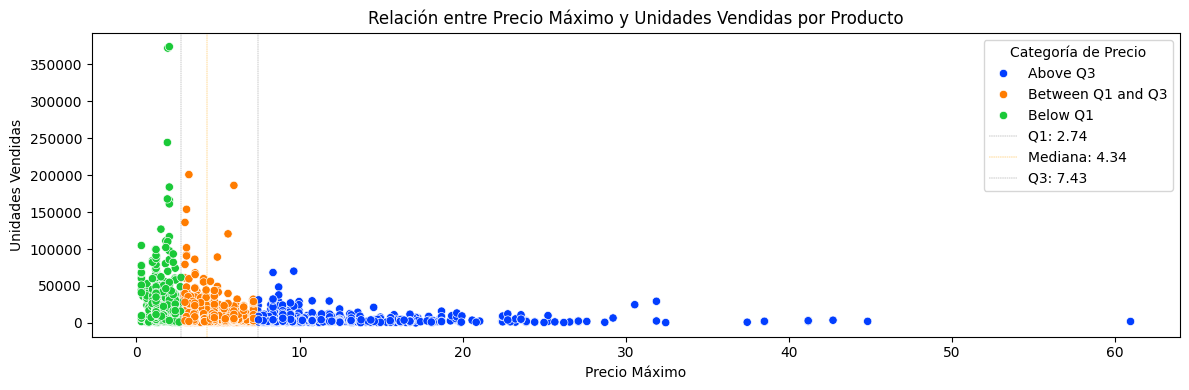

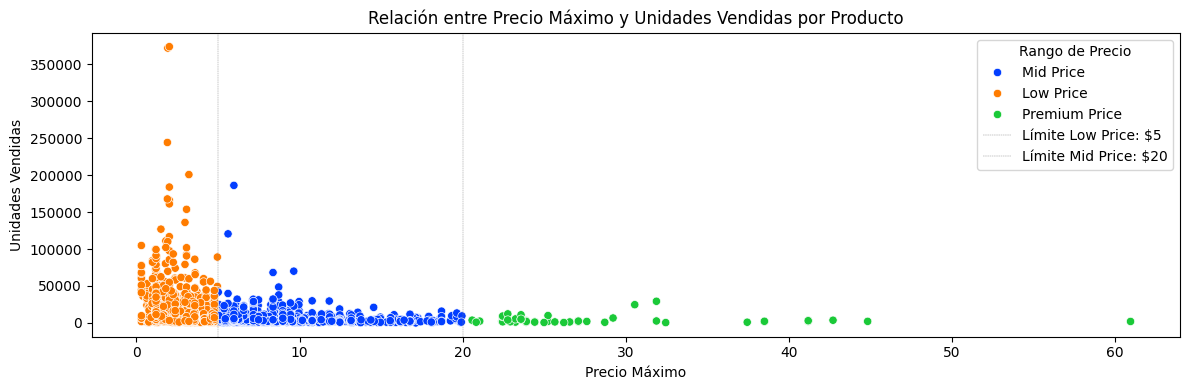

In [22]:
# Division segun cuartiles
scatter_plot_price_vs_units(df_pr)

# Division segun rangos predefinidos
scatter_plot_price_vs_units_by_range(df_pr)

In [23]:
def detailed_sales_below_max(df_pr):
    # Agrupar por 'item' y calcular el precio máximo, mínimo, y total de unidades vendidas
    summary = df_pr.groupby('item').agg(
        max_price=('sell_price', 'max'),                          # Precio máximo por producto
        min_price=('sell_price', 'min'),                          # Precio mínimo por producto
        total_units=('units', 'sum'),                             # Total de unidades vendidas
        sales_below_max=('sell_price', lambda x: (x < x.max()).sum()),  # Conteo de ventas por debajo del máximo
        units_below_max=('units', lambda x: x[df_pr['sell_price'] < df_pr['sell_price'].max()].sum()),  # Unidades vendidas por debajo del máximo
        sales_at_max=('sell_price', lambda x: (x == x.max()).sum()),  # Conteo de ventas a precio máximo
        most_frequent_price=('sell_price', lambda x: x.mode()[0])  # Precio más frecuente de venta
    ).reset_index()

    # Calcular la mayor diferencia entre el precio máximo y el mínimo
    summary['max_min_diff'] = summary['max_price'] - summary['min_price']

    # Calcular el porcentaje de ventas por debajo del máximo
    summary['percentage_below_max'] = (summary['sales_below_max'] / summary['total_units']) * 100

    # Renombrar las columnas para mayor claridad
    summary.rename(columns={'sales_below_max': 'times_below_max'}, inplace=True)

    # Reordenar columnas: Primero las de precio y luego las de unidades
    ordered_columns = [
        'item',
        'max_price',          # Precio máximo por producto.
        'min_price',          # Precio mínimo por producto
        'max_min_diff',       # Diferencia máxima entre el precio máximo y el mínimo (mayor oferta)
        'total_units',        # Total de unidades vendidas
        'units_below_max',    # Total de unidades vendidas cuando el precio no era su máximo (en oferta)
        'times_below_max',    # Número de veces que se vendió por debajo del máximo
        'sales_at_max',       # Número de veces que se vendió al precio máximo
        'most_frequent_price', # Precio al que más veces se ha vendido
        'percentage_below_max'  # Porcentaje de ventas por debajo del máximo
    ]

    summary = summary[ordered_columns]

    # Mostrar el resultado
    return summary

# Uso del código
# detailed_count = detailed_sales_below_max(df_pr)
# print(detailed_count)


In [24]:
# Uso del código
detailed_count = detailed_sales_below_max(df_pr)

# Ordenamos
detailed_count = detailed_count.sort_values(by='most_frequent_price', ascending=False)

display(detailed_count.head())
display(detailed_count.tail())

,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
352,ACCESORIES_1_361,41.2034,35.8834,5.3200,2976,2976,1662,761,39.8468,55.846774
401,ACCESORIES_1_410,38.5168,37.2001,1.3167,2224,2224,447,1409,38.5168,20.098921
384,ACCESORIES_1_393,38.5168,37.2001,1.3167,1991,1991,493,1193,38.5168,24.761426
622,HOME_&_GARDEN_1_060,37.4625,18.7500,18.7125,963,963,3,859,37.4625,0.311526
58,ACCESORIES_1_060,41.2034,35.8834,5.3200,2322,2322,1402,506,35.8834,60.378984


,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
2294,SUPERMARKET_3_070,0.3,0.06,0.24,61303,61303,5142,358,0.24,8.387844
2636,SUPERMARKET_3_412,0.3,0.06,0.24,60456,60456,5081,340,0.24,8.404459
2232,SUPERMARKET_3_007,0.3,0.06,0.24,76090,76090,4811,295,0.24,6.322776
3037,SUPERMARKET_3_816,0.3,0.06,0.24,40916,40916,4210,279,0.24,10.289373
2458,SUPERMARKET_3_234,0.3,0.06,0.24,104847,104847,5451,271,0.24,5.199004


In [25]:
# Ordenamos
detailed_count = detailed_count.sort_values(by='sales_at_max', ascending=True)

display(detailed_count.head())
display(detailed_count.tail())

,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
2208,SUPERMARKET_2_382,6.2040,3.6000,2.6040,7208,7208,3793,1,4.6560,52.622087
123,ACCESORIES_1_128,12.8345,10.6001,2.2344,2051,2051,1619,1,11.6641,78.937104
2449,SUPERMARKET_3_225,3.6000,2.3760,1.2240,9417,9417,4686,1,2.3760,49.761070
2096,SUPERMARKET_2_270,4.1760,2.4000,1.7760,2560,2560,1325,1,4.1640,51.757812
0,ACCESORIES_1_001,11.4646,6.6500,4.8146,3504,3504,2514,1,10.9858,71.746575


,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
3032,SUPERMARKET_3_811,2.256,2.256,0.00,93399,93399,0,7539,2.256,0.000000
2937,SUPERMARKET_3_714,1.896,1.776,0.12,167866,167866,346,8042,1.896,0.206117
2892,SUPERMARKET_3_668,2.016,1.896,0.12,55031,55031,77,8059,2.016,0.139921
2450,SUPERMARKET_3_226,2.016,1.896,0.12,166157,166157,78,8270,2.016,0.046944
2918,SUPERMARKET_3_694,2.016,1.896,0.12,161163,161163,86,8317,2.016,0.053362


In [26]:
# preprocesamos
# Preprocesamiento
features = detailed_count.columns.tolist()
# features = ['item','max_price','total_units'] # Se centra en unidades vendidas
features = ['item','max_price'] # Corrobora la hipotesis
# features = ['item','max_price', 'most_frequent_price'] # Muy parecido al anterior
# features = ['item','most_frequent_price'] # => Mucho solapamiento
features.remove('item')

df_to_scale = detailed_count[features]
scl = RobustScaler # para evitar outliers etc...
scaled_df, scaler = preprocess_features(df_to_scale, Scaler=scl)

In [27]:
# Silhouette
plot_silhouette(scaled_df, ran=20)

In [28]:
# Segmentacion con optimal_k
optimal_k = 3 # => Intentamos identificar low - med - premium

data = {
    'df_features': detailed_count[features],
    'features': features,
    'product_data': detailed_count,
    'X_scaled': scaled_df,
    'scaler': scaler
}

product_segments, centroid_df = segment_products_kmeans(data, n_clusters=optimal_k)

El score de silueta promedio es: 0.6267515088493837

Centroides de los clusters:
   max_price  cluster
0  21.324439        0
1   9.275602        1
2   3.389717        2


In [29]:
product_segments.head(), centroid_df.head()

(                   item  max_price  min_price  max_min_diff  total_units  \
 2208  SUPERMARKET_2_382     6.2040     3.6000        2.6040         7208   
 123    ACCESORIES_1_128    12.8345    10.6001        2.2344         2051   
 2449  SUPERMARKET_3_225     3.6000     2.3760        1.2240         9417   
 2096  SUPERMARKET_2_270     4.1760     2.4000        1.7760         2560   
 0      ACCESORIES_1_001    11.4646     6.6500        4.8146         3504   
 
       units_below_max  times_below_max  sales_at_max  most_frequent_price  \
 2208             7208             3793             1               4.6560   
 123              2051             1619             1              11.6641   
 2449             9417             4686             1               2.3760   
 2096             2560             1325             1               4.1640   
 0                3504             2514             1              10.9858   
 
       percentage_below_max  cluster  
 2208             52.622087

In [34]:
# def scatter_plot_clusters(product_segments):
#     # Crear el scatter plot
#     plt.figure(figsize=(12, 6))

#     # Scatter plot con el color basado en el cluster
#     scatter = sns.scatterplot(data=product_segments, x='max_price', y='total_units', hue='cluster', palette='viridis', alpha=0.8, s=100)

#     # Personalización del gráfico
#     plt.title('Scatter Plot de Productos por Cluster')
#     plt.xlabel('Precio Máximo')
#     plt.ylabel('Total de Unidades Vendidas')
#     plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico

#     # Ajustar el layout
#     plt.tight_layout()

#     # Mostrar el gráfico
#     plt.show()

def scatter_plot_clusters(product_segments, centroid_df):
    # Crear el scatter plot
    plt.figure(figsize=(12, 6))

    # Scatter plot con el color basado en el cluster
    scatter = sns.scatterplot(data=product_segments, x='max_price', y='total_units', hue='cluster', palette='viridis', alpha=0.8, s=100)

    # Añadir los centroides al gráfico
    # plt.scatter(centroid_df['max_price'], [product_segments['total_units'].mean()] * len(centroid_df),
    #             color='red', s=200, marker='X', label='Centroides', edgecolor='black')
    plt.scatter(centroid_df['max_price'], [product_segments['total_units'].mean()] * len(centroid_df),
                color='red', s=100, marker='X', label='Centroides', linewidths=1)

    # Personalización del gráfico
    plt.title('Scatter Plot de Productos por Cluster con Centroides')
    plt.xlabel('Precio Máximo')
    plt.ylabel('Total de Unidades Vendidas')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico

    # Ajustar el layout
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


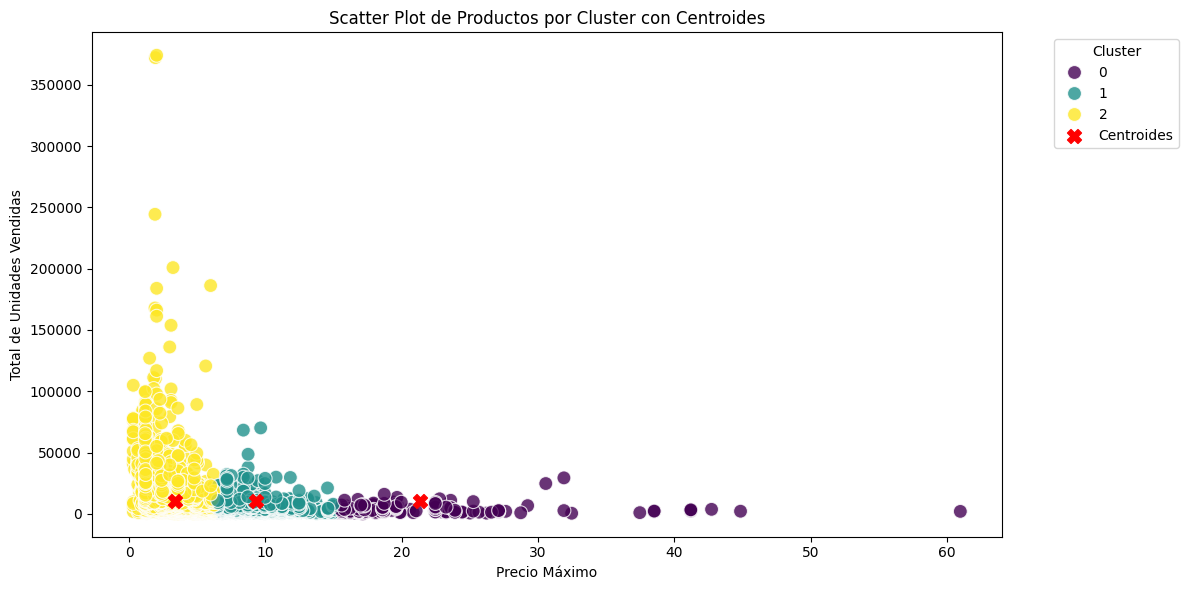

In [35]:
# Visualizacion
scatter_plot_clusters(product_segments, centroid_df)

In [111]:
# Contamos el numero de items por cluster en product_segments
display(product_segments['cluster'].value_counts())

# Mostramos el precio maximo de cada cluster
display(product_segments.groupby('cluster')['max_price'].max())

,count
cluster,
2,2101
1,807
0,141


,max_price
cluster,
0,60.9750
1,15.0024
2,6.3120


## Tareas => DELETE

In [ ]:
# Preparamos df original
# df = prepare_data(df_pr) # total_sales = raw_earn
df = prepare_data(cleaned_data) # total_sales = raw_earn => Usamos sin outliers de precios

In [ ]:
# Creacion caracteristicas para segmentacion
df_features, features, product_data = features_creation(df)

In [ ]:
# Preprocesamiento
df_to_scale = df_features[features]
scl = MinMaxScaler
# scaled_df, scaler = preprocess_features(df_to_scale, Scaler=SCALER)
scaled_df, scaler = preprocess_features(df_to_scale, Scaler=scl)

In [ ]:
# Silhouette
plot_silhouette(scaled_df, ran=20)

In [ ]:
# Segmentacion con optimal_k
optimal_k = 3 # 3 da un silueta de 0.69 => Intentamos identificar low - med - premium

data = {
    'df_features': df_features,
    'features': features,
    'product_data': product_data,
    'X_scaled': scaled_df,
    'scaler': scaler
}

product_segments, centroid_df = segment_products_kmeans(data, n_clusters=optimal_k)

In [ ]:
# Clusters asignados a items
product_segments.head()

In [ ]:
dfa = cleaned_data.copy()
segments_analysis = analyze_segments(dfa, product_segments)

In [ ]:
# visualize_results(product_segments, segments_analysis, centroid_df)
visualize_results(product_segments, centroid_df)

## PENDING: Crear diccionario de cluster con descripciones y añadir a df_items

In [ ]:
#  Vemos items por cluster
def plot_clusters_sizes(data_labeled):
    cluster_counts = data_labeled[CLUSTER_COL].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.tab10(range(len(cluster_counts))))

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}',
                ha='center', va='bottom')

    ax.set_xlabel(CLUSTER_COL)
    ax.set_ylabel('Número de items')
    ax.set_title('Número de items por cluster')
    ax.set_xticks(range(len(cluster_counts)))
    ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_counts))], rotation=0)
    plt.show()

In [ ]:
plot_clusters_sizes(product_segments)

In [ ]:
def clusters_boxplots(data_labeled):
  display(data_labeled.shape)

  # Assuming data_labeled contains your data
  num_features = len(data_labeled.columns[1:-1])  # Exclude 'item' and 'cluster'
  display(num_features)

  # Calculate number of rows and cols dynamically
  num_cols = 3  # You can adjust this to change the grid layout
  num_rows = (num_features + num_cols - 1) // num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))

  # Flatten axes array to iterate through it
  axes = axes.flatten()

  # Plot boxplots for each feature
  for i, feature in enumerate(data_labeled.columns[1:-1]):
    sns.boxplot(x=CLUSTER_COL, y=feature, data=data_labeled, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} across Clusters')

  # Hide empty subplots if any (when num_features is not divisible by num_cols)
  for i in range(num_features, num_rows * num_cols):
    if i < len(axes):  # Check if the extra subplot exists
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
# Este aqui a lo mejor no aporta mucho
clusters_boxplots(product_segments)

# Informes adicionales

In [ ]:
# INFORMES ADICIONALES
# Añadimos 'cluster' desde product_segments a df_pr usando la columna 'item'
df_pr = df_pr.merge(product_segments[['item', CLUSTER_COL]], on='item', how='left') # Aunque ya estaria hecho en segments_analysis pero no guardado en variable

In [ ]:
# Añadimos category desde df_items a df_pr
df_pr = df_pr.merge(items[['item', 'category']], on='item', how='left')

In [ ]:
# 4 Comparación del rendimiento entre clusters según categorías de productos
def analyze_category_mix(segments_analysis, product_segments):
    # Añadimos columna category a product_segments desde items
    product_segments = product_segments.merge(items[['item', 'category']], on='item', how='left')

    # Agrupamos por cluster y categoría para calcular ventas y unidades
    category_mix = product_segments.groupby(['cluster', 'category']).agg({
        'total_sales': 'sum',
        'units': 'sum'
    }).reset_index()

    # Calculamos el porcentaje de ventas de cada cluster sobre el total de ventas
    total_sales_all = segments_analysis['total_sales'].sum()
    category_mix['sales_percentage'] = (category_mix['total_sales'] / total_sales_all) * 100

    # Visualización del mix de productos por categoría en cada cluster
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x='category', y='total_sales', hue='cluster', data=category_mix, palette='viridis')

    # Añadimos el porcentaje en la parte superior de las barras
    for p in barplot.patches:
        height = p.get_height()
        barplot.text(
            p.get_x() + p.get_width() / 2.,  # Posición en X
            height,  # Posición en Y (encima de la barra)
            f'{(height / total_sales_all) * 100:.2f}%',  # Texto: porcentaje de ventas
            ha='center', va='bottom'  # Alineación del texto
        )

    plt.title('Mix de productos por categoría y cluster con porcentaje de ventas')
    plt.xlabel('Categoría de Producto')
    plt.ylabel('Ventas Totales')
    plt.show()

    return category_mix

# Llamada a la función (asumiendo que hay una columna 'category' en product_segments)
category_mix = analyze_category_mix(segments_analysis, df_pr)

In [ ]:
# 4. Comparación del rendimiento entre clusters según categorías de productos
def analyze_units_category_mix(segments_analysis, product_segments):
    # Añadimos columna category a product_segments desde items
    product_segments = product_segments.merge(items[['item', 'category']], on='item', how='left')

    # Agrupamos por cluster y categoría para calcular unidades vendidas
    category_mix = product_segments.groupby(['cluster', 'category']).agg({
        'units': 'sum'
    }).reset_index()

    # Calculamos el porcentaje de unidades de cada cluster sobre el total de unidades
    total_units_all = product_segments['units'].sum()
    category_mix['units_percentage'] = (category_mix['units'] / total_units_all) * 100

    # Visualización del mix de productos por categoría en cada cluster
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x='category', y='units', hue='cluster', data=category_mix, palette='viridis')

    # Añadimos el porcentaje en la parte superior de las barras
    for p in barplot.patches:
        height = p.get_height()
        barplot.text(
            p.get_x() + p.get_width() / 2.,  # Posición en X
            height,  # Posición en Y (encima de la barra)
            f'{(height / total_units_all) * 100:.2f}%',  # Texto: porcentaje de unidades
            ha='center', va='bottom'  # Alineación del texto
        )

    plt.title('Mix de productos por categoría y cluster con porcentaje de unidades vendidas')
    plt.xlabel('Categoría de Producto')
    plt.ylabel('Unidades Vendidas')
    plt.show()

    return category_mix

# Llamada a la función
category_mix = analyze_units_category_mix(segments_analysis, df_pr)


# Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_with_events_influence.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# products_segments.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)